# *Monod* model selection: fit to neural cell types

In the current notebook, we run the *Monod* inference pipeline on two pre-clustered mouse brain cell datasets, disaggregated into GABAergic and glutamatergic cell types, using a common set of 3,000 genes and four models (bursty, extrinsic, delayed-splicing, and delayed-efflux).

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

In [3]:
dataset_meta = ['B08','A02']

cluster_names = ['Glutamatergic','GABAergic']
dataset_names = ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names]

transcriptome_filepath = '../seq-cme-technoise/polyA_ref/gg_200524_mouse_genome_polyA_cum_1'
attribute_names=[('unspliced','spliced'),'gene_name','barcode']



In [4]:
loom_filepaths = ['/home/ggorin/count_data/loom_allen_kb/allen_'+dataset_meta[0]+'_raw.loom' ]*len(cluster_names) + \
                 ['/home/ggorin/count_data/loom_allen_kb/allen_'+dataset_meta[1]+'_raw.loom' ]*len(cluster_names) 


In [5]:
loom_filepaths

['/home/ggorin/count_data/loom_allen_kb/allen_B08_raw.loom',
 '/home/ggorin/count_data/loom_allen_kb/allen_B08_raw.loom',
 '/home/ggorin/count_data/loom_allen_kb/allen_A02_raw.loom',
 '/home/ggorin/count_data/loom_allen_kb/allen_A02_raw.loom']

In [6]:
n_datasets = len(loom_filepaths)

## Filtering

### Import metadata

In [7]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy

In [8]:
spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'
def knee_plot(S,n_cells,ax1,thr=None,viz=False):
    umi_sum = S.sum(0)
    umi_rank = np.argsort(umi_sum)
    usf = np.flip(umi_sum[umi_rank])
    if viz:
        ax1.plot(np.arange(n_cells),usf,'k')
        ax1.set_xlabel('Cell rank')
        ax1.set_ylabel('UMI count+1')
        ax1.set_yscale('log')
    if thr is not None:
        cf = umi_sum>thr
        rank_ = np.argmin(np.abs(usf-thr))
        if viz:
            ax1.plot([0,n_cells+1],thr*np.ones(2),'r--')
            ys = ax1.get_ylim()
            ax1.plot(rank_*np.ones(2),ys,'r--')
        return cf

10975
10035


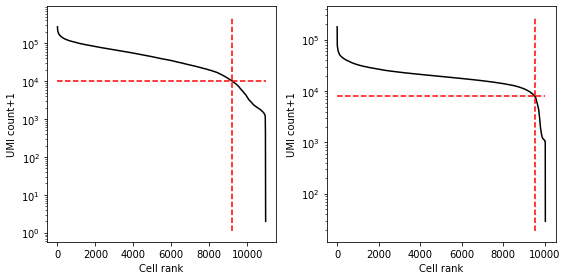

In [9]:
cf = []
thr_lb = [1e4, 8e3]
# thr_ub = [2e5, 1e5]

fig1,ax1 = plt.subplots(1,2,figsize=(8,4))

annot_names = ('sc','sn')
for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(cluster_names)*k]
    
    allen_membership = pd.read_csv(f'~/count_data/allen_metadata/{annot_names[k]}/cluster.membership.csv',skiprows = 1, names=['barcode','cluster_id'])
    allen_annot = pd.read_csv(f'~/count_data/allen_metadata/{annot_names[k]}/cluster.annotation.csv')
    allen_membership['cell_barcode'] = allen_membership['barcode'].str[:16]
    allen_membership['sample'] = allen_membership['barcode'].str[-3:]
    allen_membership['cluster_id'] = allen_membership['cluster_id'].astype("category")
    allen_annot.set_index('cluster_id',inplace=True)
    allen_annot_bc = allen_annot.loc[allen_membership['cluster_id']][['cluster_label','subclass_label','class_label']].set_index(allen_membership.index)
    meta = pd.concat((allen_membership,allen_annot_bc),axis=1)
    omitted_subtypes = ('Sncg','L6 IT Car3')
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        print(len(bcs))
        knee_plot(S+U,n_cells,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        for cluster in cluster_names:
            cf.append(np.isin(bcs,meta[(meta['sample']==dataset_meta[k]) \
                                       & (meta['class_label']==cluster) \
                                       & ~(meta['subclass_label'].isin(omitted_subtypes))]['cell_barcode'])\
                      & cf_)
fig1.tight_layout()

In [10]:
[x.sum() for x in cf]

[5352, 789, 6731, 1253]

In [11]:
[x.sum() for x in cf]

[5352, 789, 6731, 1253]

## Preprocessing

Construct a batch by finding 3,000 genes which have at least moderate expression across all datasets. Visualize the set of genes (purple) that meet the expression filtering criteria.

In [15]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230620_026_allen_1 already exists.
INFO:root:Dataset: allen_B08_Glutamatergic
INFO:root:5352 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:7176 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230620_026_allen_1/allen_B08_Glutamatergic already exists.
INFO:root:Dataset: allen_B08_GABAergic
INFO:root:789 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:5891 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230620_026_allen_1/allen_B08_GABAergic already exists.
INFO:root:Dataset: allen_A02_Glutamatergic
INFO:root:6731 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:3056 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230620_026_allen_1/allen_A02_Glutamat

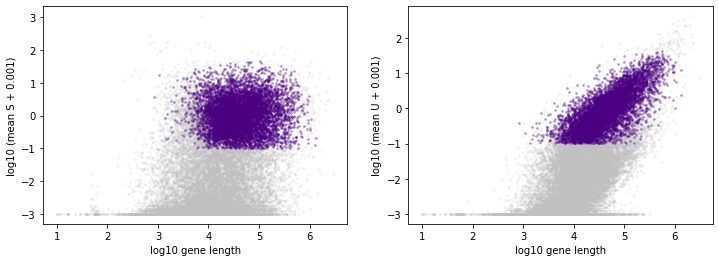

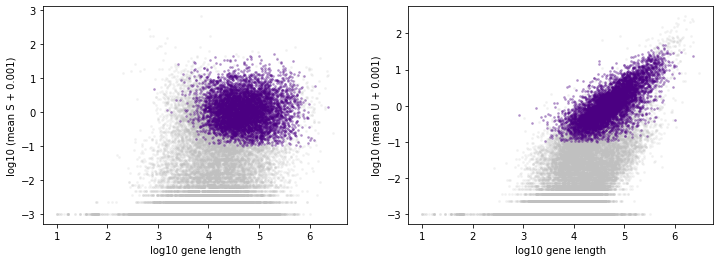

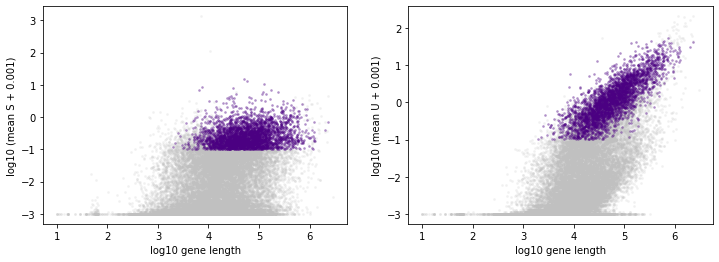

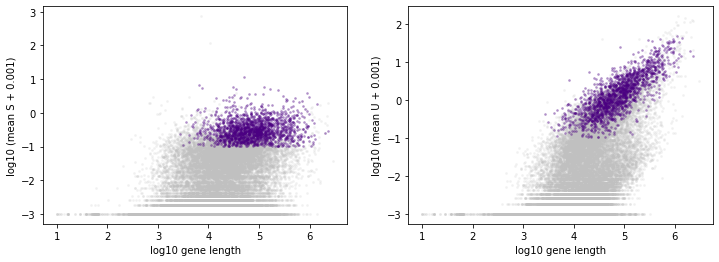

In [17]:

filt_param={
    "min_U_mean": 0.1,
    "min_S_mean": 0.1,
    "max_U_max": 200,
    "max_S_max": 200,
    "min_U_max": 3,
    "min_S_max": 3,}
# dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
#                                              transcriptome_filepath, \
#                                              dataset_names, \
#                                              attribute_names=attribute_names,\
#                                              batch_location='./fits',meta='allen',batch_id=1,\
#                                              n_genes=3000,exp_filter_threshold=None,cf=cf)
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='allen',batch_id=1,\
                                             n_genes=2000,exp_filter_threshold=1,cf=cf,
                                             filt_param=filt_param)

INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B08_Glutamatergic
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_230620_026_allen_1/genes.csv.
INFO:root:Directory ./fits/gg_230620_026_allen_1/allen_B08_Glutamatergic/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230620_026_allen_1/allen_B08_Glutamatergic/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B08_GABAergic
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_230620_026_allen_1/genes.csv.
INFO:root:Directory ./fits/gg_230620_026_allen_1/allen_B08_GABAergic/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230620_026_allen_1/allen_B08_GABAergic/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_A02_Glutamatergic
INFO:root:32285 features observed, 32005 match g

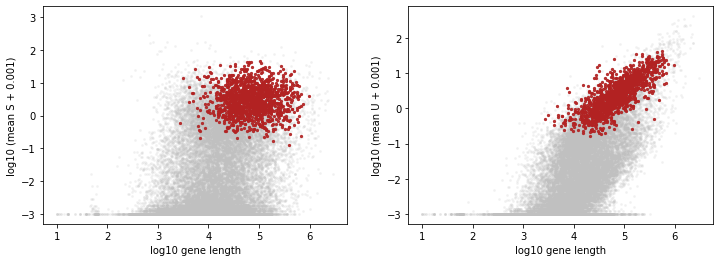

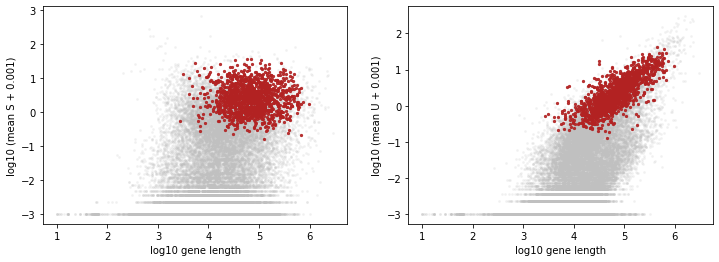

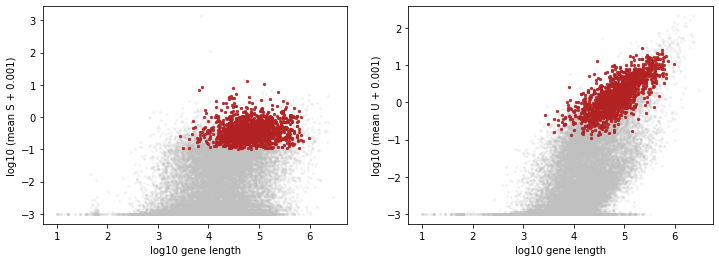

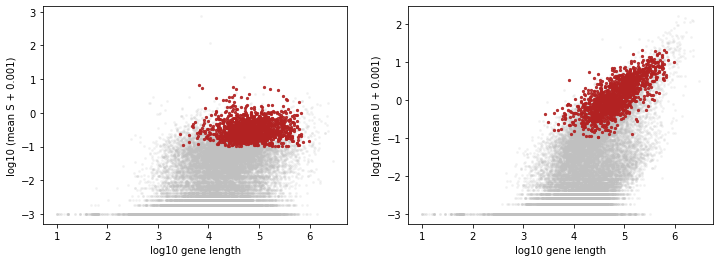

In [18]:
for i in range(n_datasets):
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])


## Inference

In [19]:
import pymc3 as pm
import theano.tensor as tt
import time
import os
import pickle
import tqdm
from tqdm import tqdm

/home/ggorin/miniconda3/lib/python3.9/site-packages/theano/scalar/basic.py:2412: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.ctor = getattr(np, o_type.dtype)
<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject
/home/ggorin/miniconda3/lib/python3.9/site-packages/arviz/__init__.py:317: PendingDeprecationWarning: The register_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps.register(name)`` instead.
  register_cmap("cet_" + name, cmap=cmap)
/home/ggorin/miniconda3/lib/python3.9/site-packages/theano/tensor/basic.py:369: De

In [20]:
dir_string

'./fits/gg_230620_026_allen_1'

In [21]:
dataset_strings

['./fits/gg_230620_026_allen_1/allen_B08_Glutamatergic',
 './fits/gg_230620_026_allen_1/allen_B08_GABAergic',
 './fits/gg_230620_026_allen_1/allen_A02_Glutamatergic',
 './fits/gg_230620_026_allen_1/allen_A02_GABAergic']

In [22]:
dir_string='./fits/gg_230620_026_allen_1'

In [23]:
dataset_strings=['./fits/gg_230620_026_allen_1/allen_B08_Glutamatergic',
 './fits/gg_230620_026_allen_1/allen_B08_GABAergic',
 './fits/gg_230620_026_allen_1/allen_A02_Glutamatergic',
 './fits/gg_230620_026_allen_1/allen_A02_GABAergic']


In [24]:
class LogLike(tt.Op):
    
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)
    
    def __init__(self, mx, data, likelihood,n_cells):
        
        # add inputs as class attributes
        self.mx = mx
        self.data = data
        self.likelihood = likelihood
        self.n_cells = n_cells
        
    def perform(self, node, inputs, outputs):
        
        phi, = inputs # this contains parmeters
        logl = self.likelihood(phi, self.mx, self.data,self.n_cells) # calls the log-likelihood function
        outputs[0][0] = np.array(logl) # output the log-likelihood


In [42]:
def get_parameter_posteriors_smc(string_ID, mx, data, n_cells, ll_func, draws_=1000, chains_=1, cores_=1):
    """"Arguments changed for sample_smc function. Here is pymc3 3.8"""
    # Define log likelihood
    logl_op = LogLike(mx, data, ll_func, n_cells)
    def logl_fun(phi):
        return logl_op(phi)
    
    # Define PyMC3 model
    model = pm.Model()
    with model:
        phi = tt.as_tensor_variable([pm.Uniform(par_names[j], lower=phys_lb[j], upper=phys_ub[j]) for j in range(fitmodel.get_num_params())])
        pm.Potential('likelihood', logl_fun(phi))
        
        
    # Run PyMC3 model
    start_time = time.time()
    with model:
        trace = pm.sample_smc(draws = draws_, chains = chains_, cores = cores_)
#     print("--- %s seconds ---" % (time.time() - start_time))        
    return trace

def ll_bursty(p, mx, data,n_cells):
    return fitmodel.eval_model_logL(p,mx,None,data,n_cells)
def ll_extrinsic(p, mx, data,n_cells):
    return fitmodel.eval_model_logL(p,mx,None,data,n_cells)
def ll_delay(p, mx, data,n_cells):
    return fitmodel.eval_model_logL(p,mx,None,data,n_cells)
def ll_delayedsplicing(p, mx, data,n_cells):
    return fitmodel.eval_model_logL(p,mx,None,data,n_cells)

def smc_wrapper(Input):
    data, mx, n_cells, gene_index, model = Input
#     d_N, d_M = data
#     mx = [np.max(d_N)+10,np.max(d_M)+10]
    if model=='bursty':
        trace_id = 'bursty_'+str(gene_index)
        trace = get_parameter_posteriors_smc(trace_id, mx, data, n_cells, ll_func=ll_bursty, chains_=1, cores_=1)
    if model=='extrinsic':
        trace_id = 'extrinsic_'+str(gene_index)
        trace = get_parameter_posteriors_smc(trace_id, mx, data, n_cells, ll_func=ll_extrinsic, chains_=1, cores_=1)
    if model=='delay':
        trace_id = 'delay_'+str(gene_index)
        trace = get_parameter_posteriors_smc(trace_id, mx, data, n_cells, ll_func=ll_delay, chains_=1, cores_=1)
    if model=='delayedsplicing':
        trace_id = 'delayedsplicing_'+str(gene_index)
        trace = get_parameter_posteriors_smc(trace_id, mx, data, n_cells, ll_func=ll_delayedsplicing, chains_=1, cores_=1)
    smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'

    with open(smc_path+'/'+trace_id+'.pickle', 'wb') as f:
        
        pickle.dump(trace, f)
    return trace

# Bursty

In [26]:

model = 'bursty'
fitmodel = monod.cme_toolbox.CMEModel('Bursty','None')
phys_lb = [-2.0, -1.8, -1.8]
phys_ub = [3.1, 3.5, 3.5]
phys_lb=np.asarray(phys_lb)
phys_ub=np.asarray(phys_ub)
par_names = ['b','beta','gamma']


In [27]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)


In [30]:
num_cores = 50
log = logging.getLogger()
log.setLevel(logging.WARNING)

Get dataset

In [31]:
dataset_ind = 0
sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
n_genes = sd.n_genes
smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
os.makedirs(smc_path,exist_ok=True)
entries = range(n_genes)
iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
    pickle.dump(par_results, f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [1:57:09<00:00,  5.33s/it]


In [32]:
dataset_ind = 1
sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
os.makedirs(smc_path,exist_ok=True)
entries = range(n_genes)
iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
    pickle.dump(par_results, f)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [1:05:20<00:00,  2.97s/it]


In [33]:
dataset_ind = 2
sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
os.makedirs(smc_path,exist_ok=True)
entries = range(n_genes)
iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
    pickle.dump(par_results, f)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [28:19<00:00,  1.29s/it]


In [34]:
dataset_ind = 3
sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
os.makedirs(smc_path,exist_ok=True)
entries = range(n_genes)
iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
    pickle.dump(par_results, f)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [22:54<00:00,  1.04s/it]


# Extrinsic

In [37]:

model = 'extrinsic'
fitmodel = monod.cme_toolbox.CMEModel('Extrinsic','None')
phys_lb = [-2.0, -1.8, -1.8]
phys_ub = [3.1, 3.5, 3.5]
phys_lb=np.asarray(phys_lb)
phys_ub=np.asarray(phys_ub)
par_names = ['alpha','beta','gamma']


In [38]:
dataset_ind = 0
sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
n_genes = sd.n_genes
smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
os.makedirs(smc_path,exist_ok=True)
entries = range(n_genes)
iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
    pickle.dump(par_results, f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [26:03<00:00,  1.19s/it]


In [39]:
dataset_ind = 1
sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
n_genes = sd.n_genes
smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
os.makedirs(smc_path,exist_ok=True)
entries = range(n_genes)
iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
    pickle.dump(par_results, f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [17:26<00:00,  1.26it/s]


In [40]:
dataset_ind = 2
sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
n_genes = sd.n_genes
smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
os.makedirs(smc_path,exist_ok=True)
entries = range(n_genes)
iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
    pickle.dump(par_results, f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [12:46<00:00,  1.72it/s]


In [41]:
dataset_ind = 3
sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
n_genes = sd.n_genes
smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
os.makedirs(smc_path,exist_ok=True)
entries = range(n_genes)
iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
    pickle.dump(par_results, f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [10:45<00:00,  2.04it/s]


# Delayed export

In [44]:

model = 'delay'
fitmodel = monod.cme_toolbox.CMEModel('Delay','None')
phys_lb = [-2.0, -1.8, -1.8]
phys_ub = [3.1, 3.5, 3.5]
phys_lb=np.asarray(phys_lb)
phys_ub=np.asarray(phys_ub)
par_names = ['alpha','beta','tauinv']

for dataset_ind in range(4):
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
    n_genes = sd.n_genes
    smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
    os.makedirs(smc_path,exist_ok=True)
    entries = range(n_genes)
    iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
    par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
    with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
        pickle.dump(par_results, f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [12:31<00:00,  1.75it/s]


# Delayed splicing

In [45]:

model = 'delayedsplicing'
fitmodel = monod.cme_toolbox.CMEModel('DelayedSplicing','None')
phys_lb = [-2.0, -1.8, -1.8]
phys_ub = [3.1, 3.5, 3.5]
phys_lb=np.asarray(phys_lb)
phys_ub=np.asarray(phys_ub)
par_names = ['alpha','tauinv','gamma']

for dataset_ind in range(4):
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[dataset_ind]+'/raw.sd')
    n_genes = sd.n_genes
    smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'
    os.makedirs(smc_path,exist_ok=True)
    entries = range(n_genes)
    iterable = [(sd.hist[gene_index],sd.M[:,gene_index],sd.n_cells,gene_index,model) for gene_index in entries]
    par_results = monod.inference.parallelize(smc_wrapper,iterable,num_cores,len(iterable))
    with open(smc_path+'/'+model+'_all.pickle', 'wb') as f:
        pickle.dump(par_results, f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [10:27<00:00,  2.10it/s]


# Move results around

In [46]:
import shutil


In [53]:
result_dir = './fits/smc_fits/'
os.makedirs(result_dir,exist_ok=True)
for dataset_ind in range(4):
    dataset_result_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results/'
    for model in ['bursty','extrinsic','delay','delayedsplicing']:
        dataset_result_file_path = dataset_result_path + model+'_all.pickle'
        destination = result_dir + dataset_names[dataset_ind]+'_'+model+'.pickle'
        print(dataset_result_file_path)
        print(destination)
        print('---')
        shutil.copy(dataset_result_file_path, destination)


./fits/gg_230620_026_allen_1/allen_B08_Glutamatergic/smc_results/bursty_all.pickle
./fits/smc_fits/allen_B08_Glutamatergic_bursty.pickle
---
./fits/gg_230620_026_allen_1/allen_B08_Glutamatergic/smc_results/extrinsic_all.pickle
./fits/smc_fits/allen_B08_Glutamatergic_extrinsic.pickle
---
./fits/gg_230620_026_allen_1/allen_B08_Glutamatergic/smc_results/delay_all.pickle
./fits/smc_fits/allen_B08_Glutamatergic_delay.pickle
---
./fits/gg_230620_026_allen_1/allen_B08_Glutamatergic/smc_results/delayedsplicing_all.pickle
./fits/smc_fits/allen_B08_Glutamatergic_delayedsplicing.pickle
---
./fits/gg_230620_026_allen_1/allen_B08_GABAergic/smc_results/bursty_all.pickle
./fits/smc_fits/allen_B08_GABAergic_bursty.pickle
---
./fits/gg_230620_026_allen_1/allen_B08_GABAergic/smc_results/extrinsic_all.pickle
./fits/smc_fits/allen_B08_GABAergic_extrinsic.pickle
---
./fits/gg_230620_026_allen_1/allen_B08_GABAergic/smc_results/delay_all.pickle
./fits/smc_fits/allen_B08_GABAergic_delay.pickle
---
./fits/gg_2

In [49]:
smc_path = dir_string+'/'+dataset_names[dataset_ind]+'/smc_results'

In [50]:
smc_path

'./fits/gg_230620_026_allen_1/allen_A02_GABAergic/smc_results'

In [64]:
# trace

<MultiTrace: 1 chains, 1000 iterations, 6 variables>

In [65]:
# sr = monod.analysis.load_search_results('/home/ggorin/projects/cme-delays/fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Bursty_None_1x1/grid_scan_results_upd.res')

INFO:root:Grid scan results loaded from /home/ggorin/projects/cme-delays/fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Bursty_None_1x1/grid_scan_results_upd.res.


In [66]:
sd.gene_names

array(['AC149090.1', 'Cnot11', 'Ncstn', ..., 'Kantr', '5330434G04Rik',
       'Gm47283'], dtype='<U16')

In [67]:
mx

array([16, 18])

In [68]:
fitmodel.get_MoM(sd.moments[gene_index],phys_lb,phys_ub,None)

array([-0.71136254, -0.17093081, -0.67586951])

In [69]:
sd.moments[gene_index]

{'S_mean': 0.92152466367713,
 'U_mean': 0.2881165919282511,
 'S_var': 1.1287444616488034,
 'U_var': 0.344118874298699}

In [70]:
trace.b.mean()

-0.598860187968168

In [71]:
trace.gamma.mean()

-0.5620491754841744

In [72]:
10**(trace.b.mean()-trace.beta.mean())

0.29109464859895456

In [73]:
10**(trace.b.mean()-trace.gamma.mean())

0.9187323049089063

In [74]:
np.asarray([trace.b.mean(),trace.beta.mean(),trace.gamma.mean()])

array([-0.59886019, -0.06289441, -0.56204918])

In [75]:
sr.phys_optimum[gene_index]

array([-0.59658429, -0.0611481 , -0.55957951])

In [76]:
fitmodel.get_MoM(sd.moments[gene_index],phys_lb,phys_ub,None)

array([-0.71136254, -0.17093081, -0.67586951])

In [80]:
ll_bursty(np.asarray([trace.b.mean(),trace.beta.mean(),trace.gamma.mean()]),mx,data,n_cells)

-10567.572728316114

In [81]:
ll_bursty(sr.phys_optimum[gene_index],mx,data,n_cells)

-10567.56970764645

In [82]:
ll_bursty(fitmodel.get_MoM(sd.moments[gene_index],phys_lb,phys_ub,None),mx,data,n_cells)

-10571.767999103795

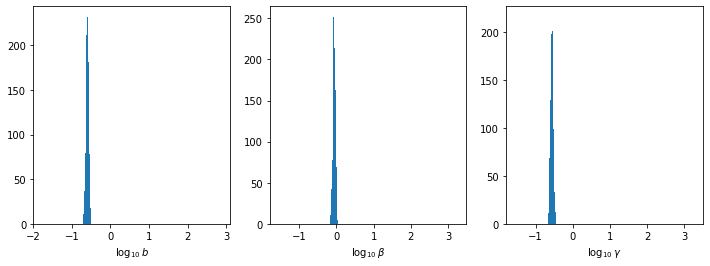

In [83]:
fig1,ax1=plt.subplots(1,3,figsize=(12,4))
ax1[0].hist(trace.b)
ax1[1].hist(trace.beta)
ax1[2].hist(trace.gamma)
for k in range(3):
    ax1[k].set_xlim([phys_lb[k],phys_ub[k]])
    ax1[k].set_xlabel(fitmodel.get_log_name_str()[k])

In [84]:
# eva

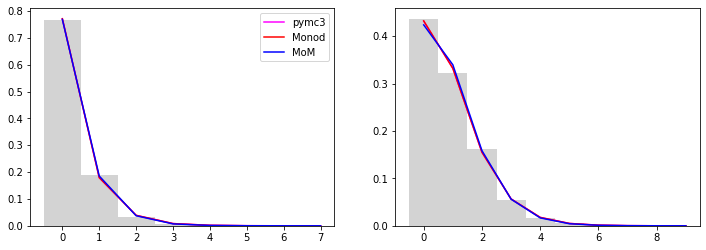

In [85]:
fig1,ax1=plt.subplots(1,2,figsize=(12,4))
raw = sd.layers[:,gene_index,:]
lims = [raw[0].max()+2,raw[1].max()+2]
bins = np.arange(lims[0])-0.5
ax1[0].hist(raw[0],bins,color='lightgray',density=True)
bins = np.arange(lims[1])-0.5
ax1[1].hist(raw[1],bins,color='lightgray',density=True)


p_pymc = np.asarray([trace.b.mean(),trace.beta.mean(),trace.gamma.mean()])
p_Monod = sr.phys_optimum[gene_index]
p_MoM = fitmodel.get_MoM(sd.moments[gene_index],phys_lb,phys_ub,None)
p_s = [p_pymc,p_Monod,p_MoM]
P_pymc = fitmodel.eval_model_pss(p_pymc, mx, None)
ax1[0].plot(P_pymc.sum(1)[:lims[0]],c='magenta',label='pymc3')
ax1[1].plot(P_pymc.sum(0)[:lims[1]],c='magenta',label='pymc3')
P_Monod = fitmodel.eval_model_pss(p_Monod, mx, None)
ax1[0].plot(P_Monod.sum(1)[:lims[0]],c='red',label='Monod')
ax1[1].plot(P_Monod.sum(0)[:lims[1]],c='red',label='Monod')
P_MoM = fitmodel.eval_model_pss(p_MoM, mx, None)
ax1[0].plot(P_MoM.sum(1)[:lims[0]],c='blue',label='MoM')
ax1[1].plot(P_MoM.sum(0)[:lims[1]],c='blue',label='MoM')
ax1[0].legend()

In [86]:
np.sum(np.log(P_pymc[tuple(sd.hist[gene_index][0].T)])*sd.hist[gene_index][1])*sd.n_cells

-10567.572728316116

In [87]:
sd.hist[gene_index][1].shape

(33,)

In [88]:
names = 'pymc3','Monod','MoM'
for k,p in enumerate(p_s):
    print(names[k])
    print('KLD: {:.2f}'.format(fitmodel.eval_model_kld(p,mx,None,data)))
    P = fitmodel.eval_model_pss(p, mx, None)
    print('LogL: {:.2f}'.format(np.sum(np.log(P[tuple(sd.hist[gene_index][0].T)])*sd.hist[gene_index][1])))
    print('Log L: {:.2f}'.format(fitmodel.eval_model_logL(p,mx,None,data,sd.n_cells)))
    print('---')

pymc3
KLD: 0.00
LogL: -1.97
Log L: -10567.57
---
Monod
KLD: 0.00
LogL: -1.97
Log L: -10567.57
---
MoM
KLD: 0.01
LogL: -1.98
Log L: -10571.77
---


In [162]:
# trace.gamma

In [56]:
# j=0
# print(par_names[j])
# print(phys_lb[j])
# print(phys_ub[j])
# x = pm.Uniform(par_names[j], lower=phys_lb[j], upper=phys_ub[j])

In [ ]:
# def get_parameter_posteriors_smc(string_ID, mx, data, ll_func, draws_=1000, chains_=2, cores_=2):
# #     """"Arguments changed for sample_smc function. Here is pymc3 3.8"""
#     # Parameter bounds
# #     epsilon = 0.005
# #     x_min, x_max = epsilon, 1-epsilon
# #     y_min, y_max = epsilon, 1-epsilon
    
#     # Define log likelihood
#     logl_op = LogLike(mx, data, ll_func)
#     def logl_fun(phi):
#         return logl_op(phi)
    
#     # Define PyMC3 model
#     model = pm.Model()
#     with model:
#         # Priors
#         x_ = pm.Uniform('x', lower=x_min, upper=x_max)
#         y_ = pm.Uniform('y', lower=y_min, upper=y_max)
#         z_ = pm.Uniform('z', lower=x_min, upper=x_max)
#         q_ = pm.Uniform('q', lower=y_min, upper=y_max)

#         phi = tt.as_tensor_variable([x_, y_, z_, q_])

#         # Likelihood
#         pm.Potential('likelihood', logl_fun(phi))
        
        
#     # Run PyMC3 model
#     #start_time = ti.time()
#     with model:
#         trace = pm.sample_smc(draws = draws_, chains = chains_, cores = cores_)
#     #print("--- %s seconds ---" % (ti.time() - start_time))
        
#     # Plot and save trace
#     #with model:
#     #    axes = az.plot_trace(trace)
#     #    fig = axes.ravel()[0].figure
#     #    #fig.savefig("smc_results/trace_"+string_ID+".png", bbox_inches='tight')
#     #    fig.savefig("trace_"+string_ID+".pdf", bbox_inches='tight')
        
#     return trace


Define parameter bounds, then iterate over datasets and perform the fits.

In [16]:
phys_lb = [-2.0, -1.8, -1.8]
phys_ub = [3.1, 3.5, 3.5]
samp_lb = [1,1]
samp_ub = [1,1]
gridsize = [1,1]
gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':5}
# gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1}

INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Directory ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Extrinsic_None_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Extrinsic_None_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B08_Glutamatergic
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_220909_024_allen_2/genes.csv.
INFO:root:Directory ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Extrinsic_None_1x1/analysis_figures 

/home/ggorin/projects/monod/src/monod/cme_toolbox.py:584: RuntimeWarning: divide by zero encountered in double_scalars
  gamma = alpha / moments["S_mean"]


INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_220909_024_allen_2/allen_A02_GABAergic/Extrinsic_None_1x1/analysis_figures created.
INFO:root:Runtime: 303.7 seconds.


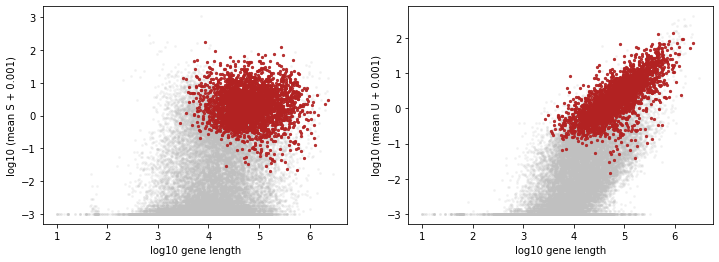

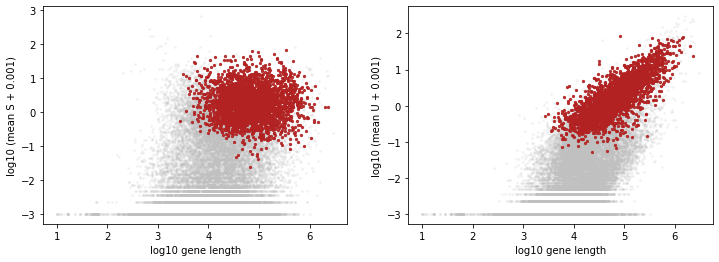

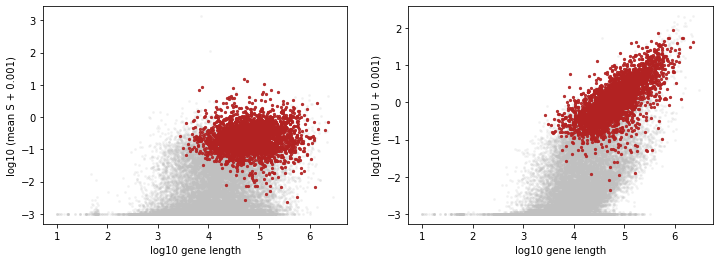

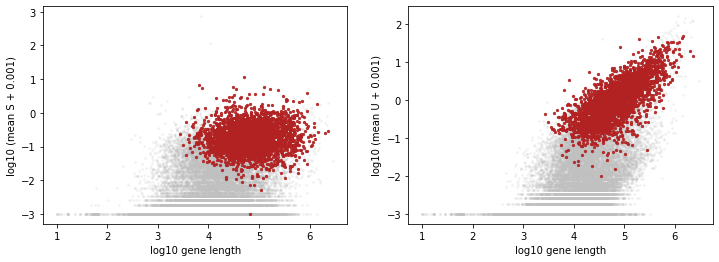

In [17]:
result_strings_ext = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Extrinsic','None')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = False,
                gradient_params = gradient_params)
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
    result_strings_ext.append(full_result_string)

INFO:root:Grid scan results loaded from ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Extrinsic_None_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/raw.sd.
INFO:root:Figure stored to ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Extrinsic_None_1x1/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 2405 genes out of 3000. Runtime: 1.7 seconds.
INFO:root:Figure stored to ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Extrinsic_None_1x1/analysis_figures/length_dependence.png.


/home/ggorin/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:4509: RuntimeWarning: overflow encountered in double_scalars
  fac1 = a / np.pi * np.exp(gamma)
/home/ggorin/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:4509: RuntimeWarning: overflow encountered in exp
  fac1 = a / np.pi * np.exp(gamma)


INFO:root:Figure stored to ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Extrinsic_None_1x1/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_220909_024_allen_2/analysis_figures created.
INFO:root:Grid scan results loaded from ./fits/gg_220909_024_allen_2/allen_B08_GABAergic/Extrinsic_None_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_220909_024_allen_2/allen_B08_GABAergic/raw.sd.
INFO:root:Figure stored to ./fits/gg_220909_024_allen_2/allen_B08_GABAergic/Extrinsic_None_1x1/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 175 genes out of 3000. Runtime: 1.5 seconds.
INFO:root:Figure stored to ./fits/gg_220909_024_allen_2/allen_B08_GABAergic/Extrinsic_None_1x1/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_220909_024_allen_2/allen_B08_GABAergic/Extrinsic_None_1x1/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_220909_024_allen_2/an

/home/ggorin/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:4509: RuntimeWarning: overflow encountered in exp
  fac1 = a / np.pi * np.exp(gamma)
/home/ggorin/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:4511: RuntimeWarning: invalid value encountered in multiply
  return fac1 * sc.k1e(a * sq) * np.exp(b*x - a*sq) / sq
/home/ggorin/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:4509: RuntimeWarning: overflow encountered in double_scalars
  fac1 = a / np.pi * np.exp(gamma)


INFO:root:Figure stored to ./fits/gg_220909_024_allen_2/allen_A02_GABAergic/Extrinsic_None_1x1/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_220909_024_allen_2/analysis_figures already exists.


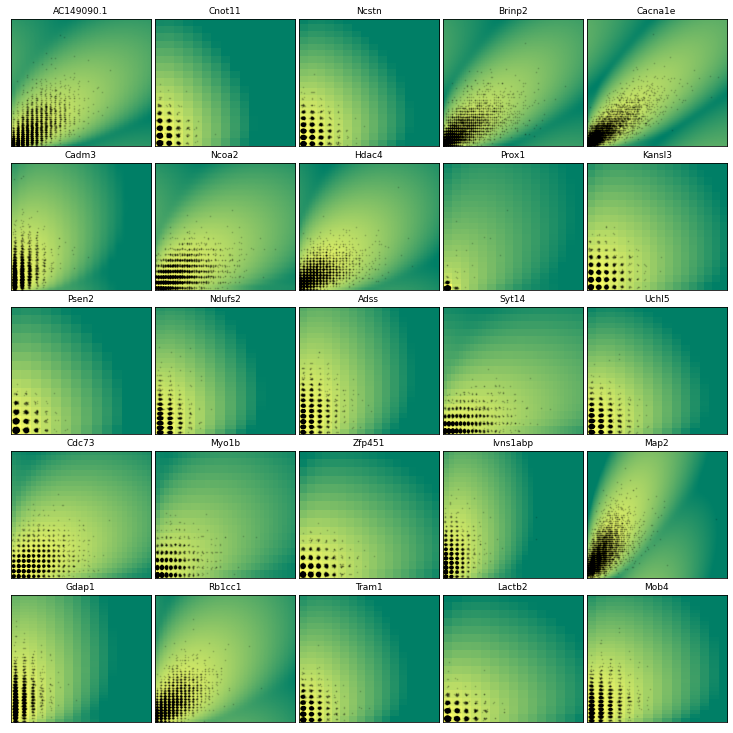

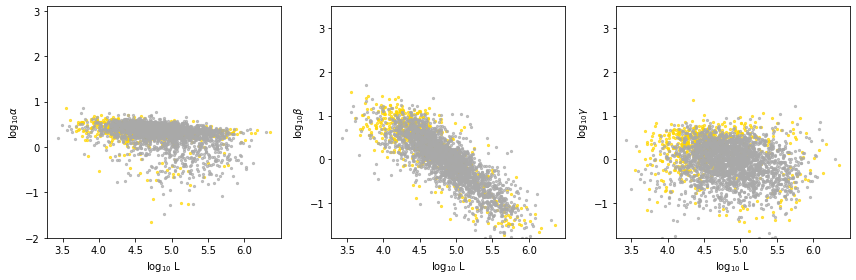

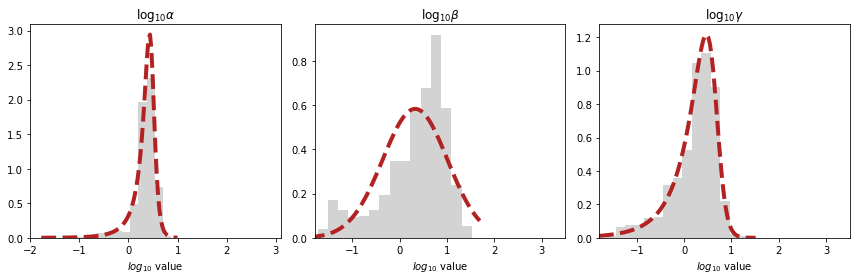

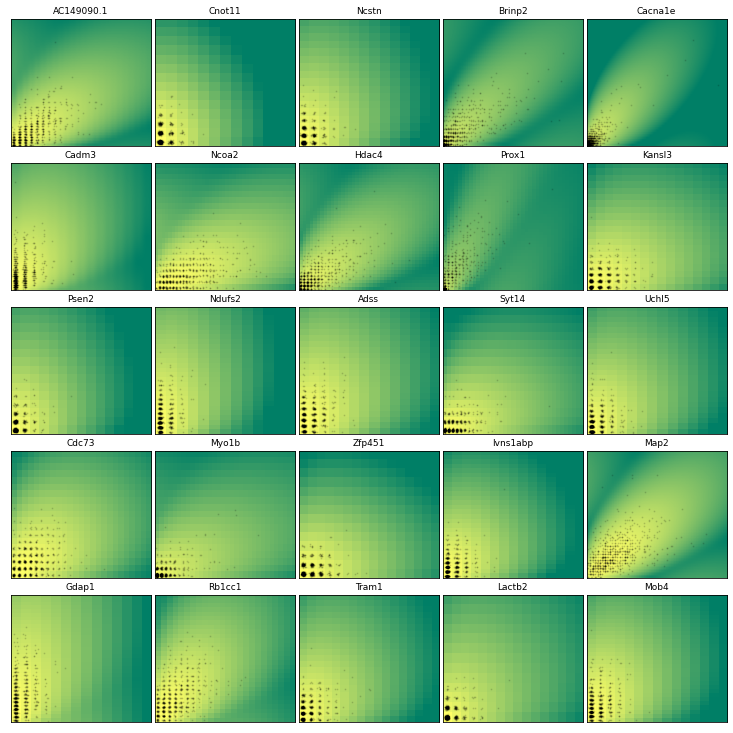

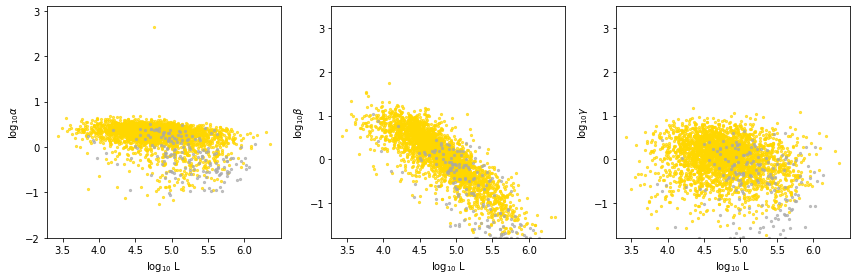

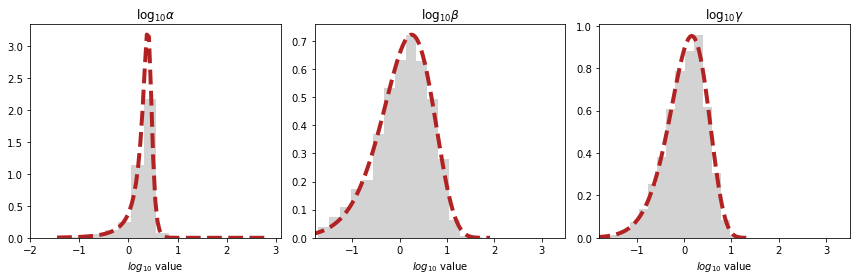

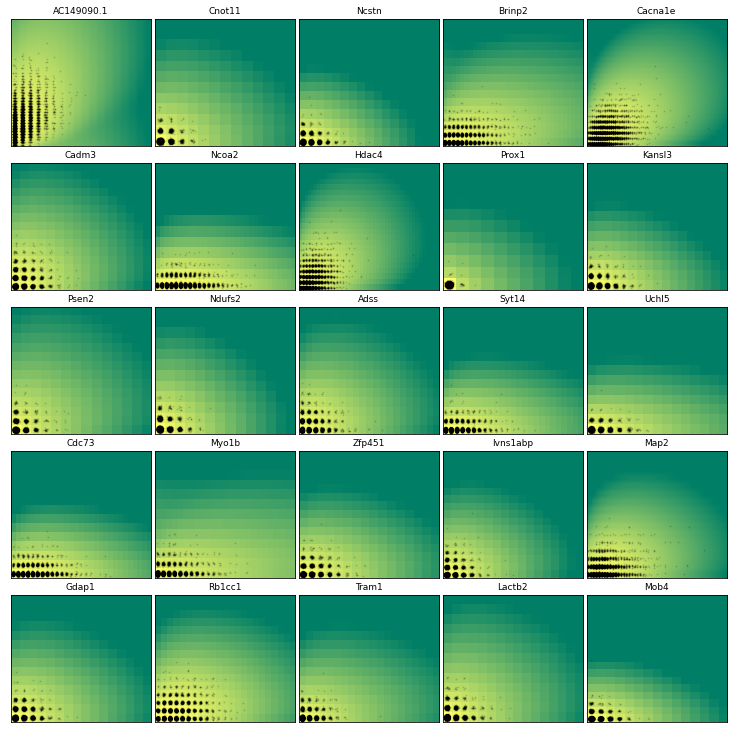

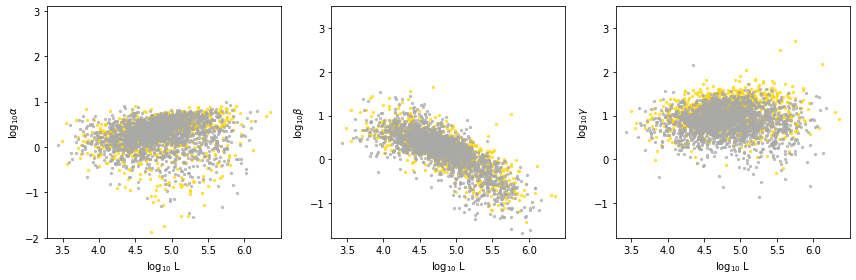

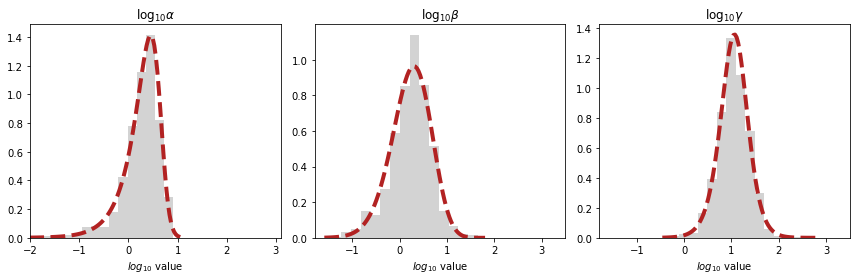

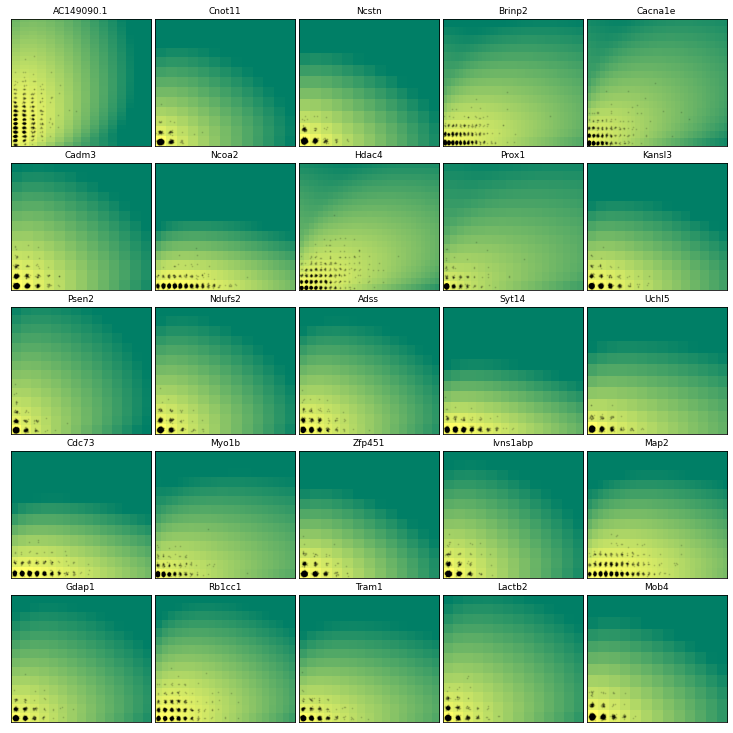

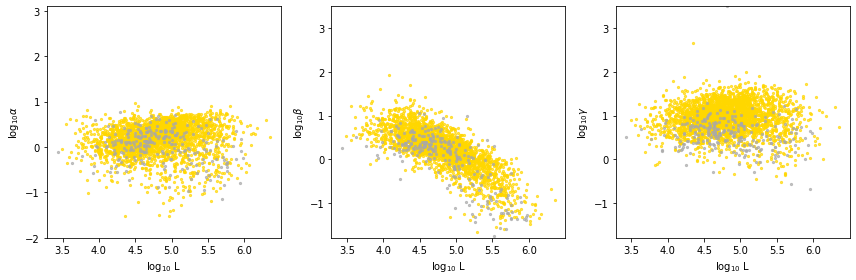

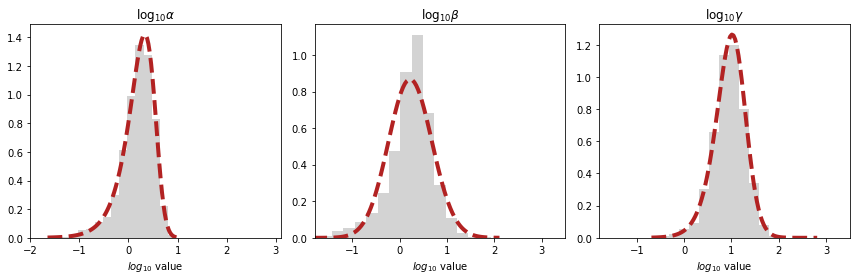

In [18]:
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings_ext[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    sr.find_sampling_optimum()

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd)

#     sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=False,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    

In [19]:

result_strings_burst = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','None')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = False,
                gradient_params = gradient_params)
    search_data = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
    result_strings_burst.append(full_result_string)

INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Directory ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Bursty_None_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Bursty_None_1x1/parameters.pr.
INFO:root:Search data loaded from ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Bursty_None_1x1/analysis_figures created.
INFO:root:Runtime: 3321.7 seconds.
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Directory ./fits/gg_220909_024_allen_2/allen_B08_GABAergic/Bursty_None_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_220909_024_allen_2/allen_B08_GABAergic/Bursty_None_1x1/parameters.pr.
INFO:r

/home/ggorin/projects/monod/src/monod/cme_toolbox.py:543: RuntimeWarning: divide by zero encountered in double_scalars
  gamma = b / moments["S_mean"]


INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_220909_024_allen_2/allen_A02_GABAergic/Bursty_None_1x1/analysis_figures created.
INFO:root:Runtime: 669.8 seconds.


INFO:root:Grid scan results loaded from ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Bursty_None_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/raw.sd.
INFO:root:Figure stored to ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Bursty_None_1x1/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 1532 genes out of 3000. Runtime: 5.9 seconds.
INFO:root:Figure stored to ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Bursty_None_1x1/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Bursty_None_1x1/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_220909_024_allen_2/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_220909_024_allen_2/allen_B08_GABAergic/Bursty_None_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_2209

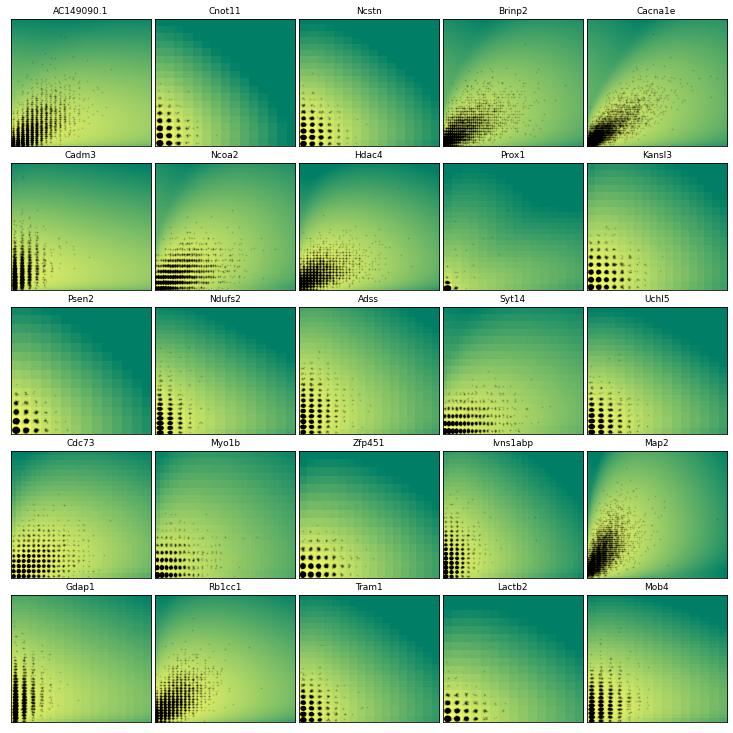

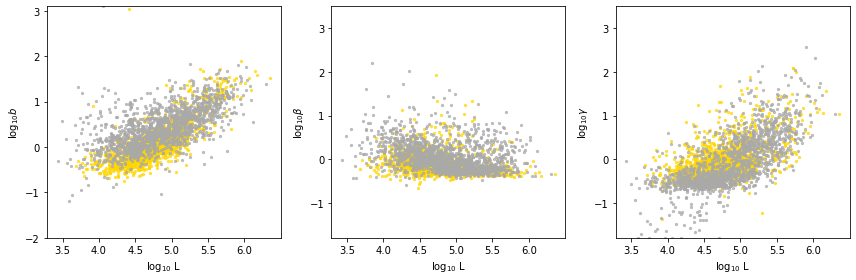

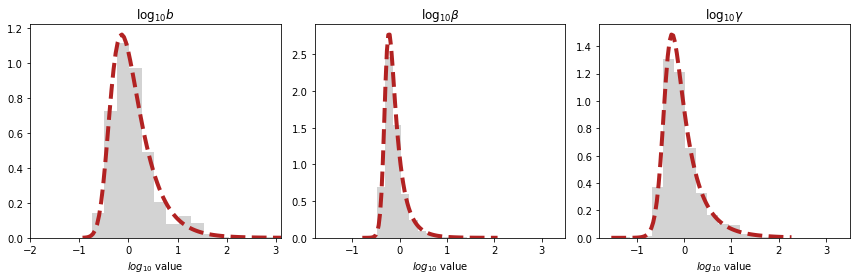

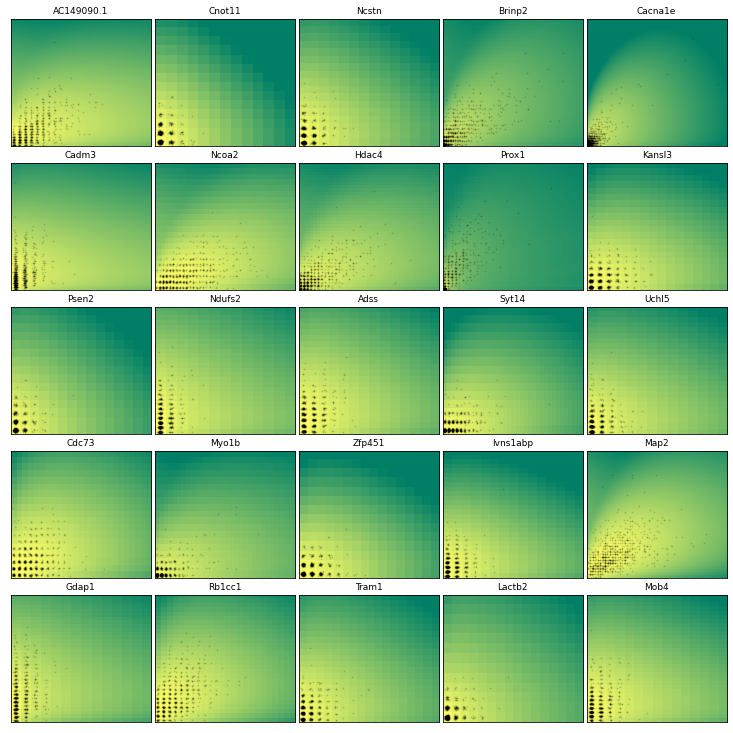

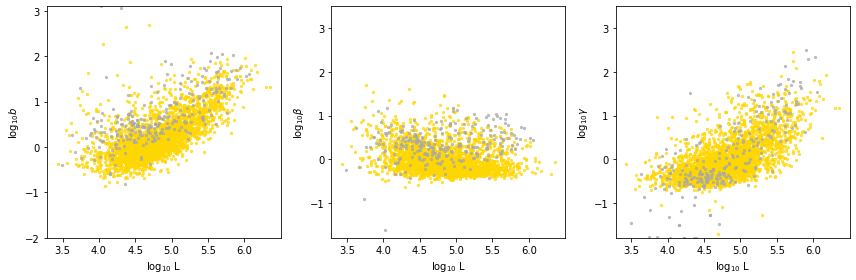

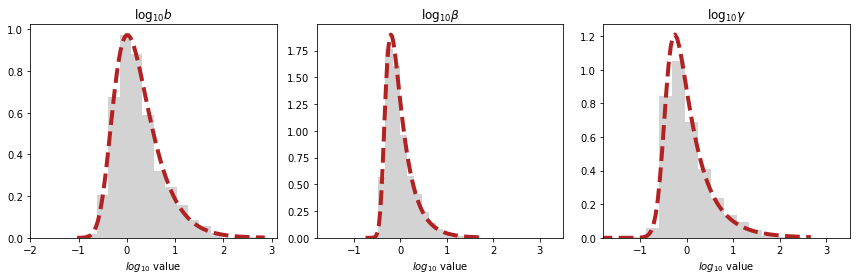

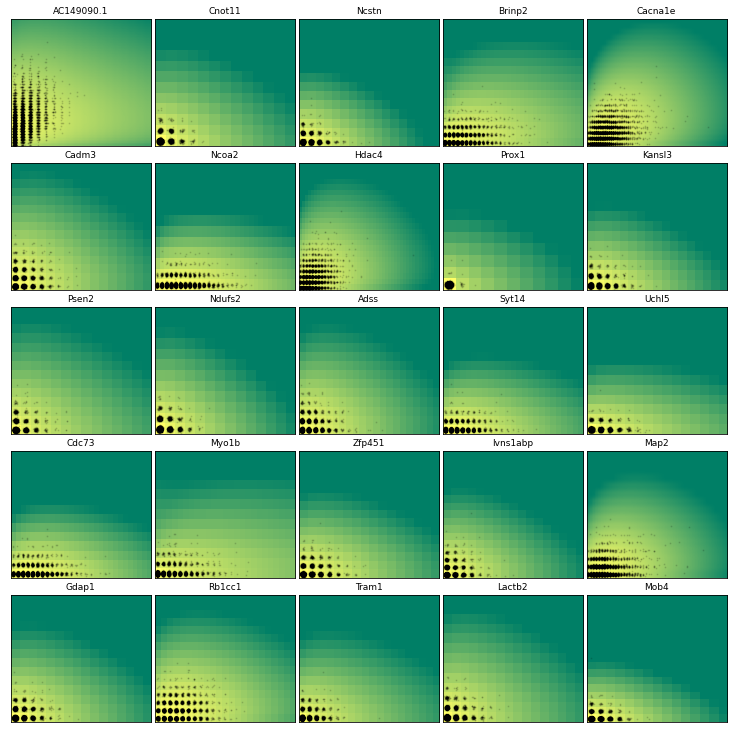

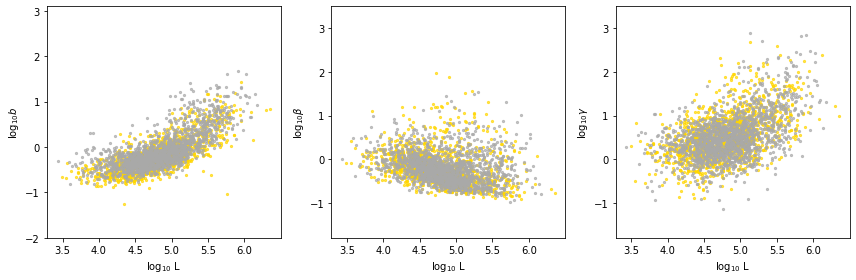

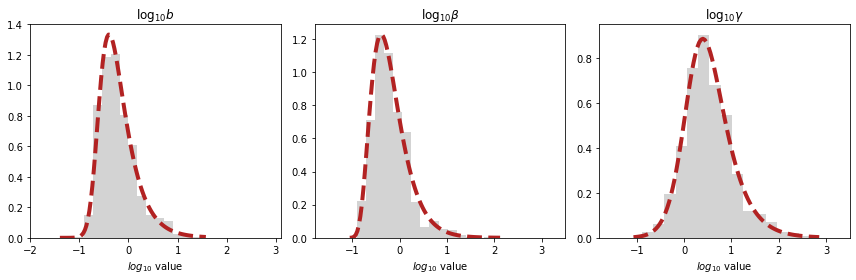

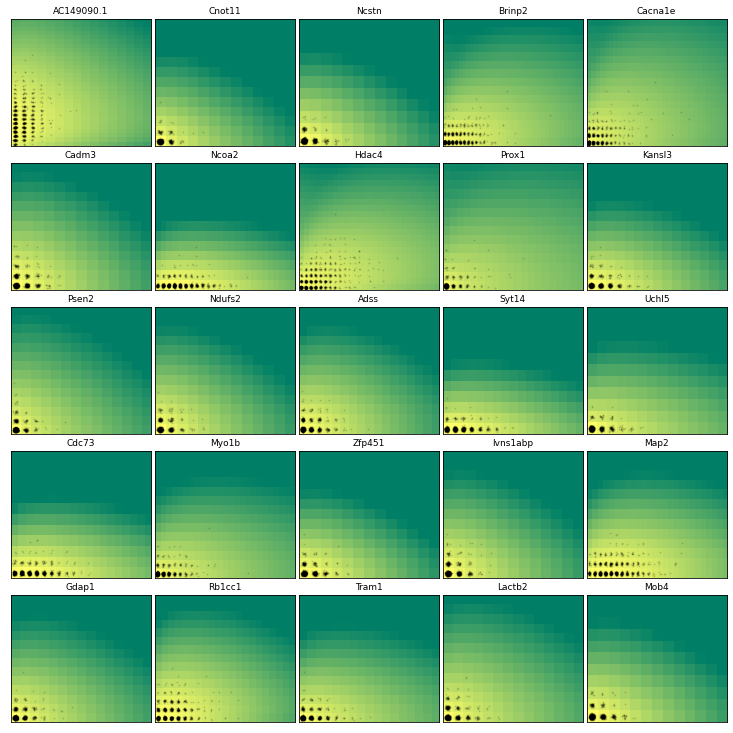

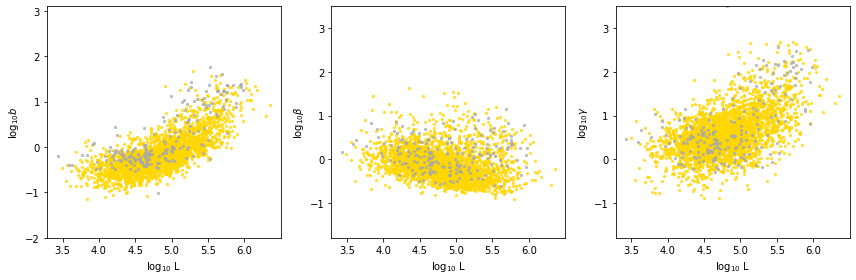

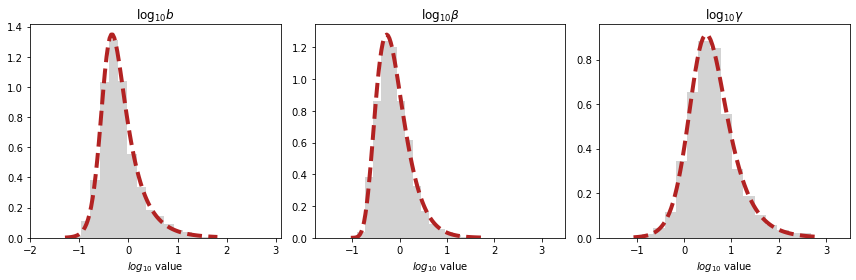

In [20]:
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings_burst[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    sr.find_sampling_optimum()

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd)

#     sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=False,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    

In [21]:
result_strings_delay = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Delay','None')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = False,
                gradient_params = gradient_params)
    search_data = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
    result_strings_delay.append(full_result_string)

INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Directory ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Delay_None_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Delay_None_1x1/parameters.pr.
INFO:root:Search data loaded from ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Delay_None_1x1/analysis_figures created.
INFO:root:Runtime: 973.2 seconds.
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Directory ./fits/gg_220909_024_allen_2/allen_B08_GABAergic/Delay_None_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_220909_024_allen_2/allen_B08_GABAergic/Delay_None_1x1/parameters.pr.
INFO:root:Se

/home/ggorin/projects/monod/src/monod/cme_toolbox.py:556: RuntimeWarning: divide by zero encountered in double_scalars
  tauinv = b / moments["S_mean"]


INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_220909_024_allen_2/allen_A02_GABAergic/Delay_None_1x1/analysis_figures created.
INFO:root:Runtime: 359.0 seconds.


INFO:root:Grid scan results loaded from ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Delay_None_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/raw.sd.
INFO:root:Figure stored to ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Delay_None_1x1/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 1620 genes out of 3000. Runtime: 2.3 seconds.
INFO:root:Figure stored to ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Delay_None_1x1/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Delay_None_1x1/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_220909_024_allen_2/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_220909_024_allen_2/allen_B08_GABAergic/Delay_None_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_220909_02

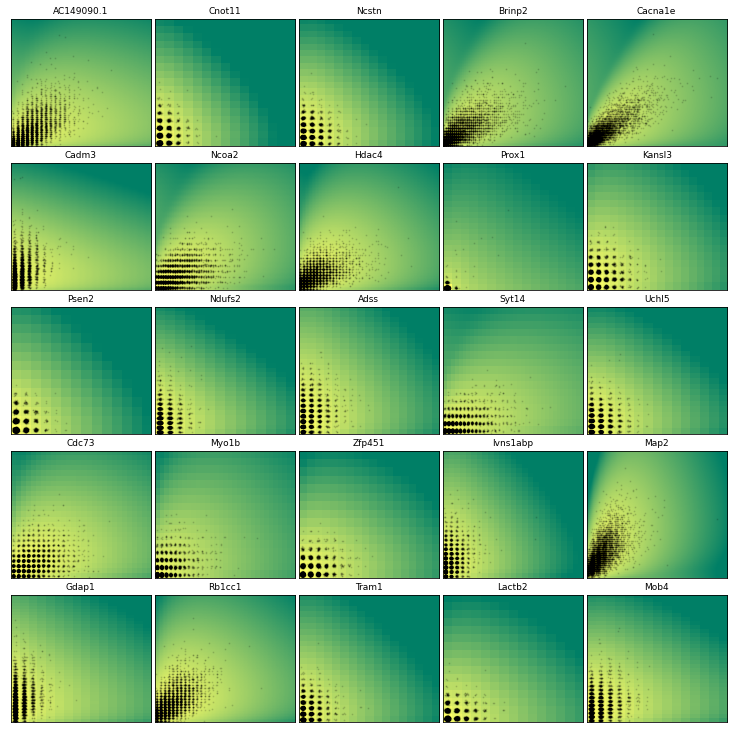

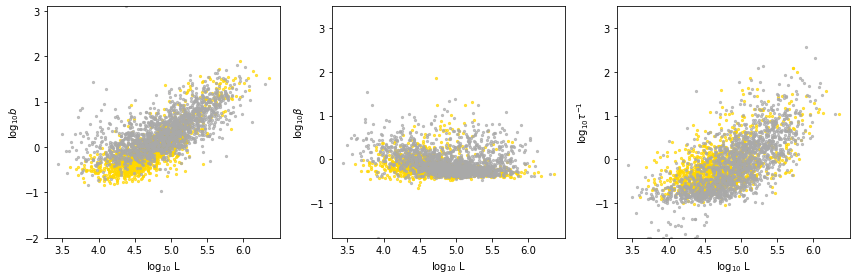

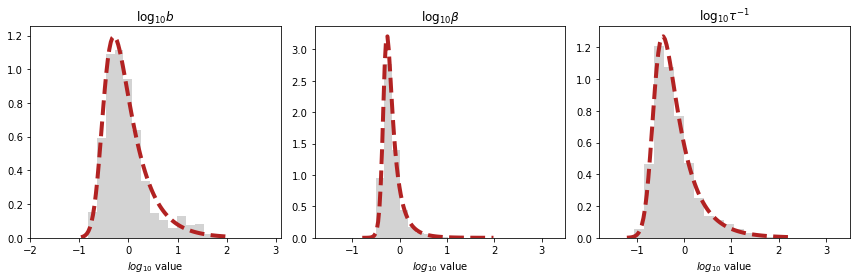

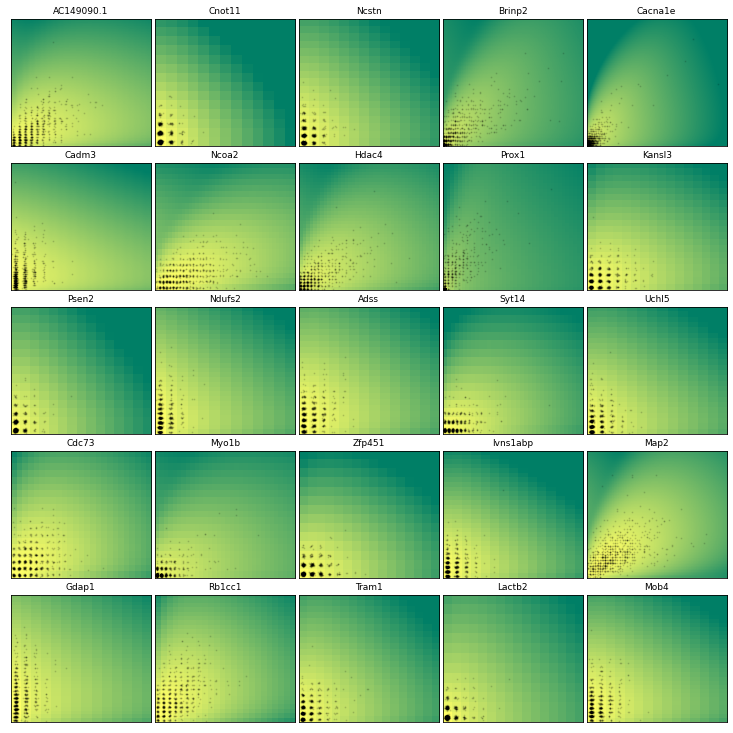

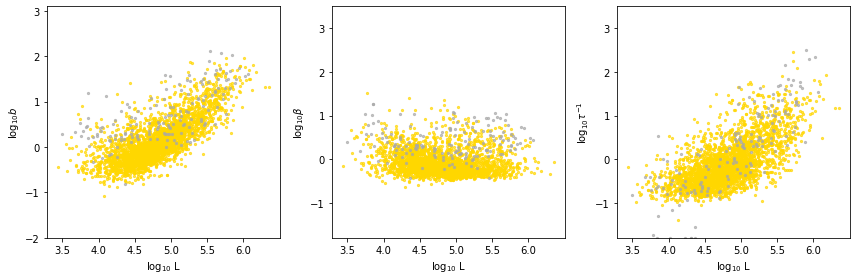

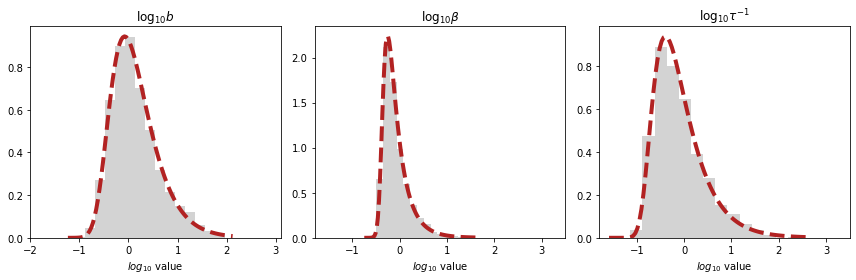

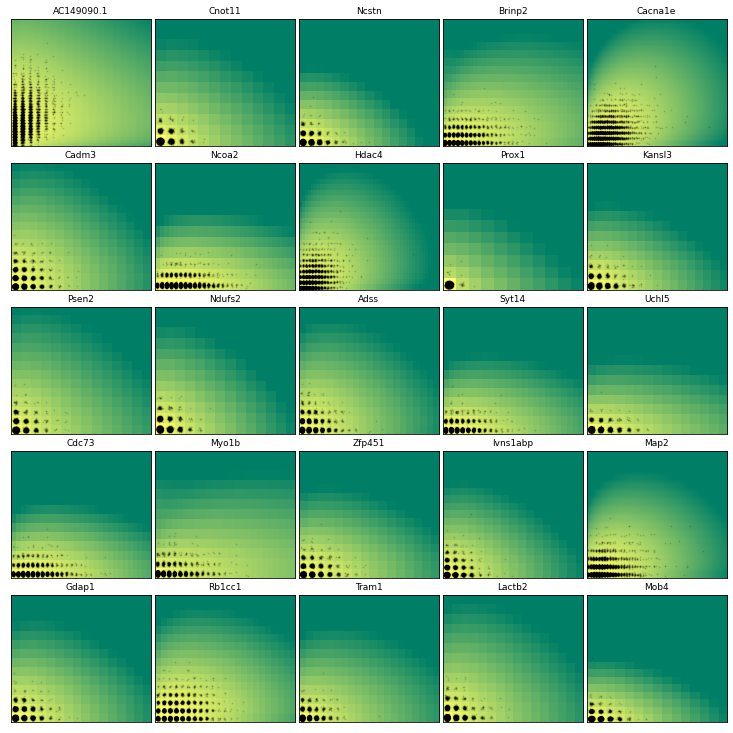

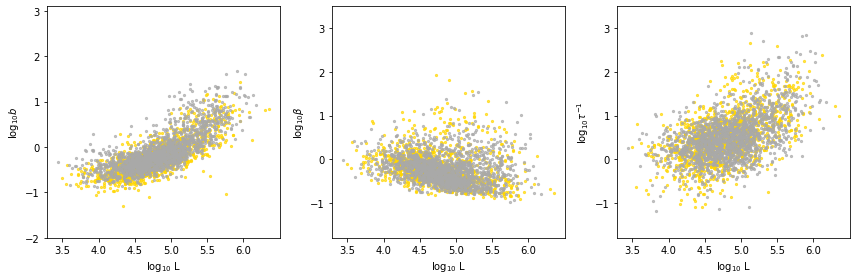

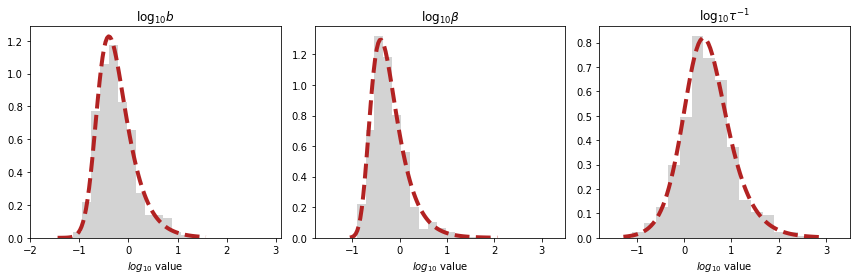

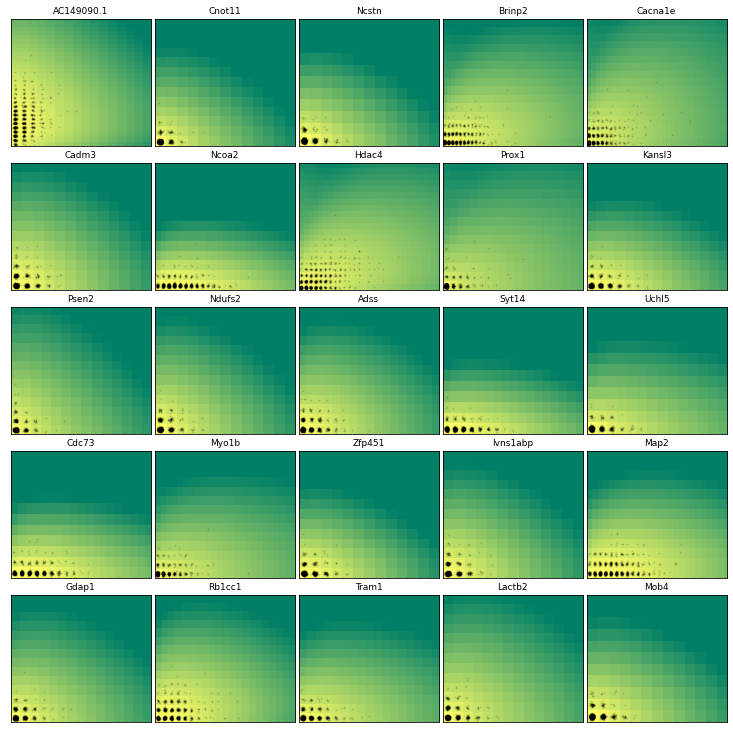

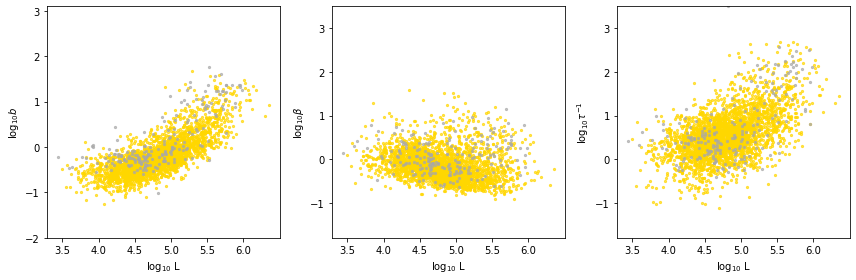

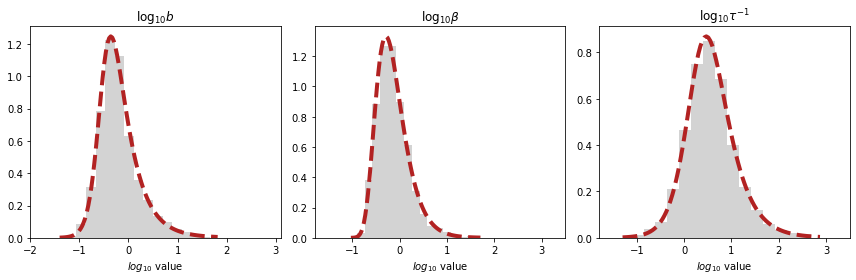

In [22]:
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings_delay[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    sr.find_sampling_optimum()

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd)

#     sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=False,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    

In [23]:
result_strings_delayed_splicing = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('DelayedSplicing','None')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = False,
                gradient_params = gradient_params)
    search_data = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
    result_strings_delayed_splicing.append(full_result_string)

INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Directory ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/DelayedSplicing_None_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/DelayedSplicing_None_1x1/parameters.pr.
INFO:root:Search data loaded from ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/DelayedSplicing_None_1x1/analysis_figures created.
INFO:root:Runtime: 632.4 seconds.
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Directory ./fits/gg_220909_024_allen_2/allen_B08_GABAergic/DelayedSplicing_None_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_220909_024_allen_2/allen_B08_GABAergic/De

/home/ggorin/projects/monod/src/monod/cme_toolbox.py:564: RuntimeWarning: divide by zero encountered in double_scalars
  gamma = b / moments["S_mean"]


INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_220909_024_allen_2/allen_A02_GABAergic/DelayedSplicing_None_1x1/analysis_figures created.
INFO:root:Runtime: 276.5 seconds.


INFO:root:Grid scan results loaded from ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/DelayedSplicing_None_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/raw.sd.
INFO:root:Figure stored to ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/DelayedSplicing_None_1x1/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 2958 genes out of 3000. Runtime: 1.7 seconds.
INFO:root:Figure stored to ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/DelayedSplicing_None_1x1/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/DelayedSplicing_None_1x1/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_220909_024_allen_2/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_220909_024_allen_2/allen_B08_GABAergic/DelayedSplicing_None_1x1/grid_scan_results.res.
INF

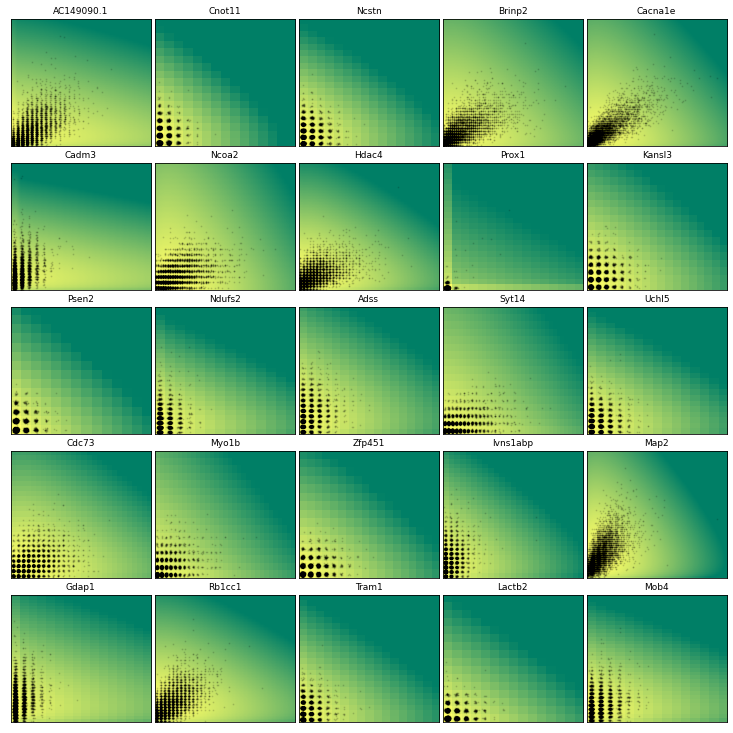

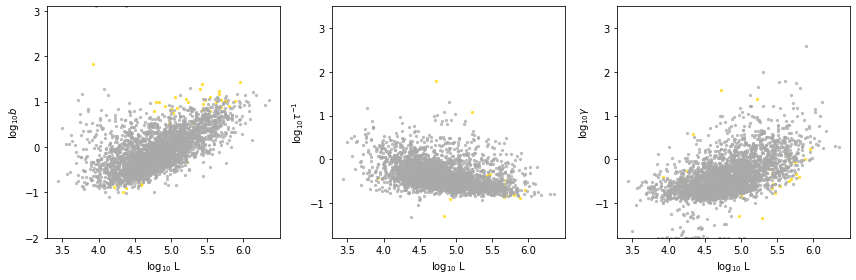

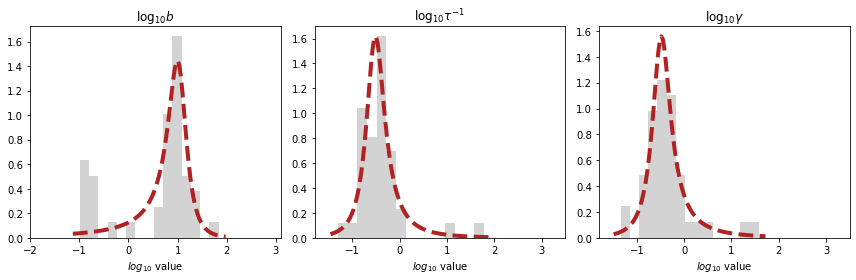

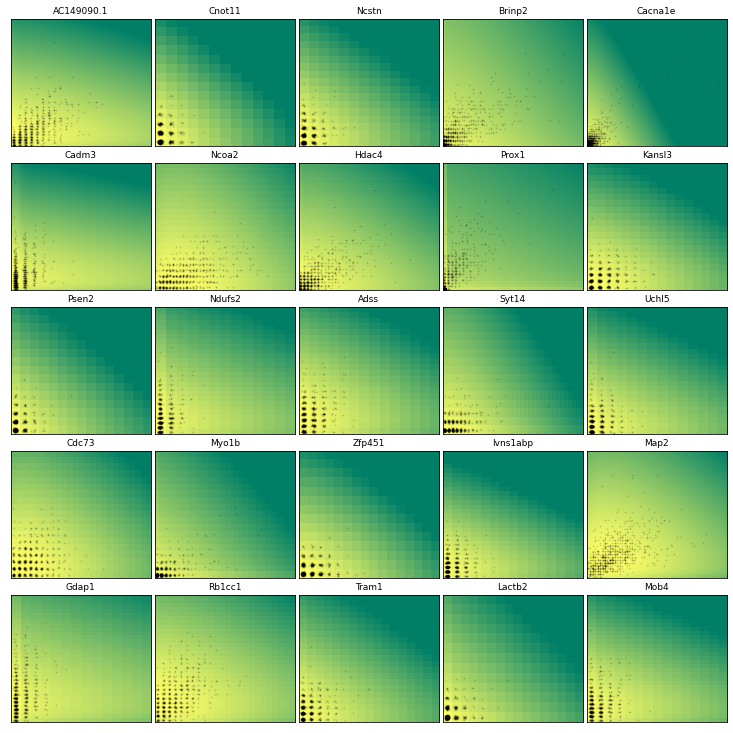

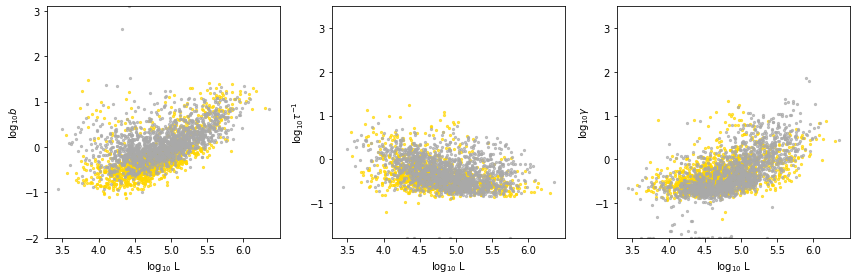

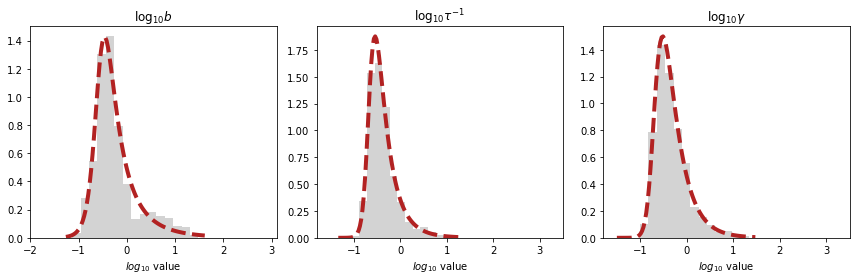

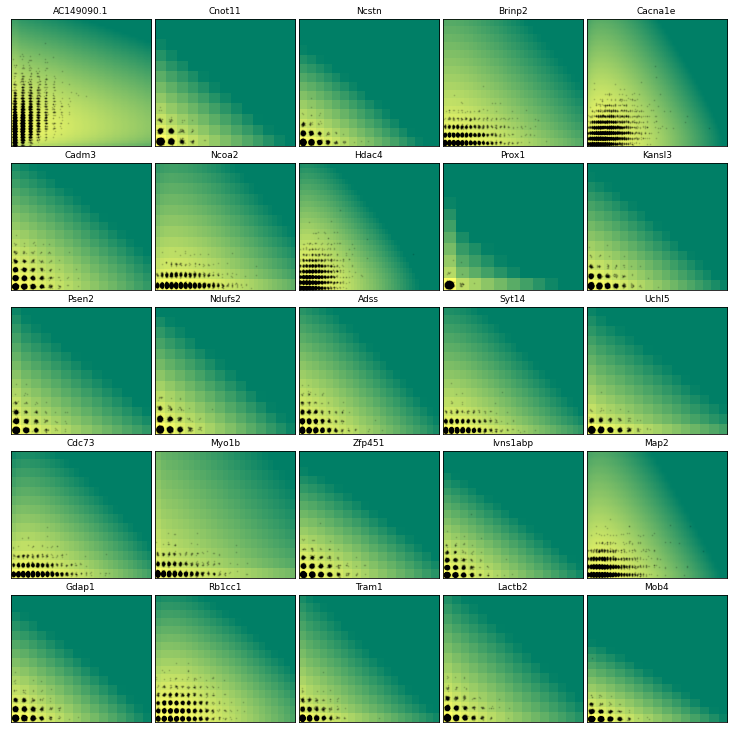

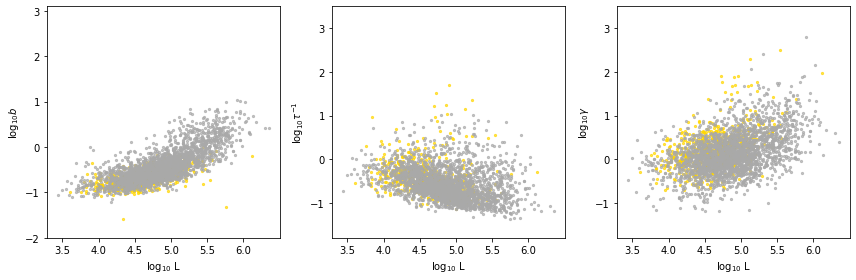

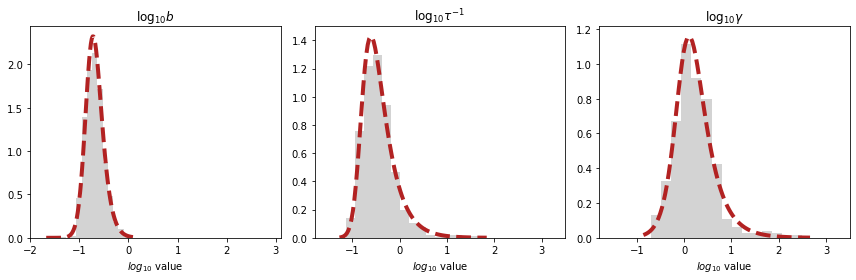

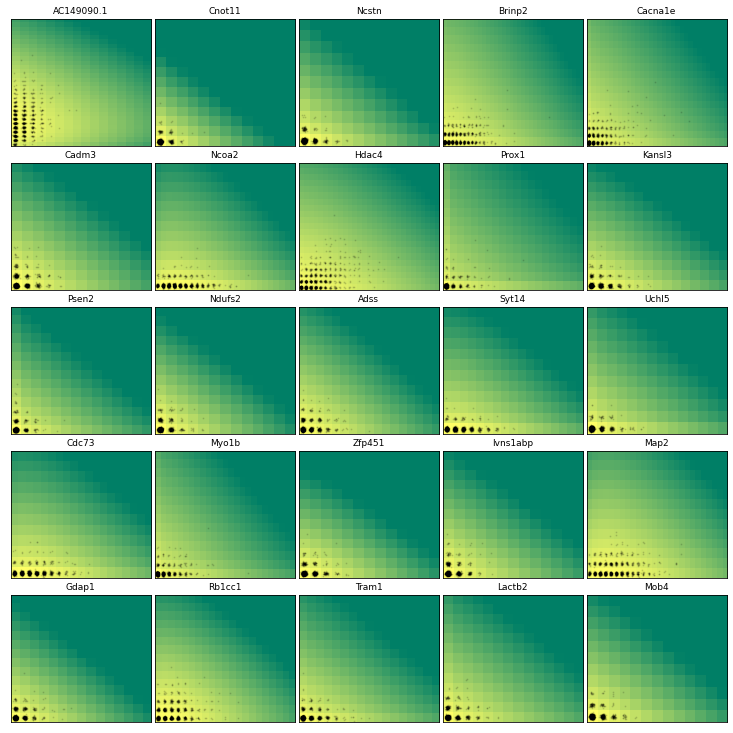

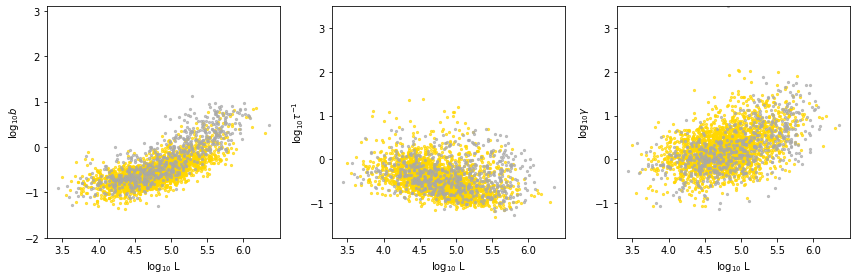

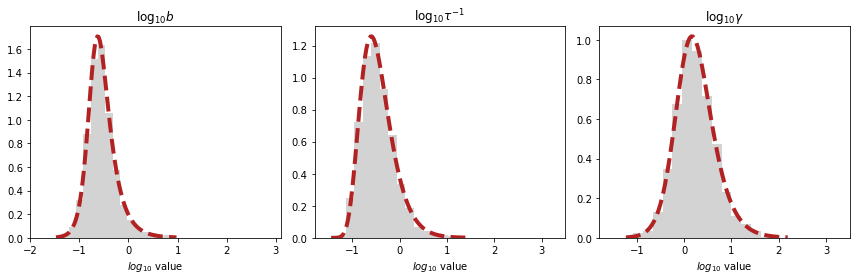

In [24]:
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings_delayed_splicing[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    sr.find_sampling_optimum()

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd)

#     sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=False,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    

In [25]:
result_strings_ext

['./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Extrinsic_None_1x1/grid_scan_results.res',
 './fits/gg_220909_024_allen_2/allen_B08_GABAergic/Extrinsic_None_1x1/grid_scan_results.res',
 './fits/gg_220909_024_allen_2/allen_A02_Glutamatergic/Extrinsic_None_1x1/grid_scan_results.res',
 './fits/gg_220909_024_allen_2/allen_A02_GABAergic/Extrinsic_None_1x1/grid_scan_results.res']

In [26]:
result_strings_burst

['./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Bursty_None_1x1/grid_scan_results.res',
 './fits/gg_220909_024_allen_2/allen_B08_GABAergic/Bursty_None_1x1/grid_scan_results.res',
 './fits/gg_220909_024_allen_2/allen_A02_Glutamatergic/Bursty_None_1x1/grid_scan_results.res',
 './fits/gg_220909_024_allen_2/allen_A02_GABAergic/Bursty_None_1x1/grid_scan_results.res']

In [27]:
result_strings_delay

['./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Delay_None_1x1/grid_scan_results.res',
 './fits/gg_220909_024_allen_2/allen_B08_GABAergic/Delay_None_1x1/grid_scan_results.res',
 './fits/gg_220909_024_allen_2/allen_A02_Glutamatergic/Delay_None_1x1/grid_scan_results.res',
 './fits/gg_220909_024_allen_2/allen_A02_GABAergic/Delay_None_1x1/grid_scan_results.res']

In [28]:
result_strings_delayed_splicing

['./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/DelayedSplicing_None_1x1/grid_scan_results.res',
 './fits/gg_220909_024_allen_2/allen_B08_GABAergic/DelayedSplicing_None_1x1/grid_scan_results.res',
 './fits/gg_220909_024_allen_2/allen_A02_Glutamatergic/DelayedSplicing_None_1x1/grid_scan_results.res',
 './fits/gg_220909_024_allen_2/allen_A02_GABAergic/DelayedSplicing_None_1x1/grid_scan_results.res']

In [29]:
result_strings_ext=[x[:-4]+'_upd.res' for x in result_strings_ext]
result_strings_burst=[x[:-4]+'_upd.res' for x in result_strings_burst]
result_strings_delay=[x[:-4]+'_upd.res' for x in result_strings_delay]
result_strings_delayed_splicing=[x[:-4]+'_upd.res' for x in result_strings_delayed_splicing]


## Analysis

In [30]:
sr_arr_full = [[monod.analysis.load_search_results(result_strings_ext[i]),\
                monod.analysis.load_search_results(result_strings_burst[i]),\
                monod.analysis.load_search_results(result_strings_delay[i]),\
                monod.analysis.load_search_results(result_strings_delayed_splicing[i])] for i in range(n_datasets)]

INFO:root:Grid scan results loaded from ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Extrinsic_None_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Bursty_None_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/Delay_None_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/DelayedSplicing_None_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220909_024_allen_2/allen_B08_GABAergic/Extrinsic_None_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220909_024_allen_2/allen_B08_GABAergic/Bursty_None_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220909_024_allen_2/allen_B08_GABAergic/Delay_None_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/

In [31]:
sd_arr = [monod.analysis.load_search_data(dir_string+'/'+x+'/raw.sd') for x in dataset_names]

INFO:root:Search data loaded from ./fits/gg_220909_024_allen_2/allen_B08_Glutamatergic/raw.sd.
INFO:root:Search data loaded from ./fits/gg_220909_024_allen_2/allen_B08_GABAergic/raw.sd.
INFO:root:Search data loaded from ./fits/gg_220909_024_allen_2/allen_A02_Glutamatergic/raw.sd.
INFO:root:Search data loaded from ./fits/gg_220909_024_allen_2/allen_A02_GABAergic/raw.sd.


In [32]:
model_logL = [[sr.get_logL(sd) for sr in x] for x,sd in zip(sr_arr_full,sd_arr)]

In [33]:
model_logL = np.asarray(model_logL)

In [34]:
model_names=('delayed deg.','extrinsic','delayed splic.')

delayed deg.
Glutamatergic
0.5521385648639096
0.20635451505016722
GABAergic
0.41652613827993257
0.38366666666666666
extrinsic
Glutamatergic
0.8911273039005573
0.4498469908194492
GABAergic
0.8475630833045281
0.6146911519198665
delayed splic.
Glutamatergic
0.984027105517909
0.6216877293110477
GABAergic
0.9676827029012119
0.6978260869565217


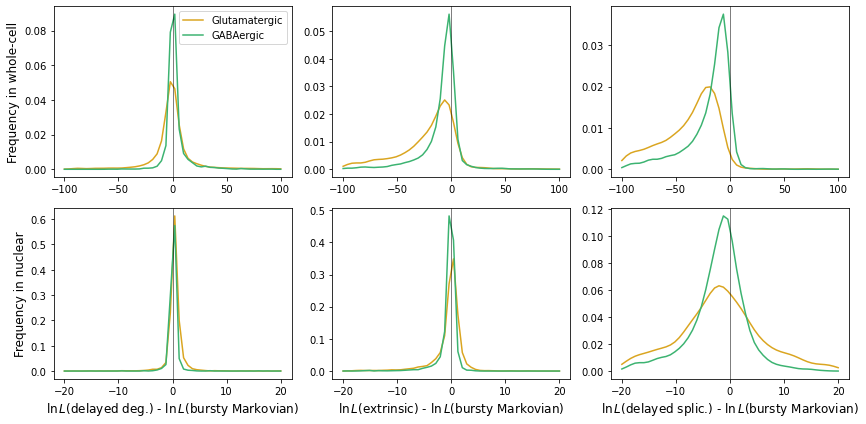

In [35]:
fig1,ax1=plt.subplots(2,3,figsize=(12,6))
fs=12
alf =0.5
colors = ('goldenrod','mediumseagreen','lightgray')

for model_index,mi in enumerate([[2,1],[0,1],[3,1]]):
    print(model_names[model_index])
    for cluster_index,di in enumerate([[0,2],[1,3]]):
        print(cluster_names[cluster_index])
        
        lim = 100
        sc_lr=model_logL[di[0],mi[0]] - model_logL[di[0],1]
        sc_lr = sc_lr[np.abs(sc_lr)<lim]
        sc_kde=scipy.stats.gaussian_kde(sc_lr)
        x = np.linspace(-lim,lim)
        ax1[0,model_index].plot(x,sc_kde(x),\
                             label=f'{cluster_names[cluster_index]}',color=colors[cluster_index])
        

        lim = 20
        sn_lr=model_logL[di[1],mi[0]] - model_logL[di[1],1]
        sn_lr = sn_lr[np.abs(sn_lr)<lim]
        sn_kde=scipy.stats.gaussian_kde(sn_lr)
        x = np.linspace(-lim,lim)
        ax1[1,model_index].plot(x,sn_kde(x),\
                             label=f'{cluster_names[cluster_index]}',color=colors[cluster_index])

        print((sc_lr<0).mean())
        print((sn_lr<0).mean())

    for i in range(2):
        yl = ax1[i,model_index].get_ylim()
        ax1[i,model_index].plot([0,0],yl,'k-',linewidth=.5)
        ax1[i,model_index].set_ylim(yl)
    ax1[1,model_index].set_xlabel(fr'$\ln L$({model_names[model_index]}) - $\ln L$(bursty Markovian)',fontsize=fs)
ax1[0,0].set_ylabel('Frequency in whole-cell',fontsize=fs)
ax1[1,0].set_ylabel('Frequency in nuclear',fontsize=fs)
ax1[0,0].legend()
fig1.tight_layout()
plt.savefig('./fig/likelihood_ratio_allen.png',dpi=450)

### 